In [6]:
import json
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from matplotlib.pyplot import figure
import matplotlib as mpl
import seaborn as sns

from market_sub import *
from Build_Win_Lag import build_win_feature, build_lag_feature

import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
from tigramite.independence_tests.robust_parcorr import RobustParCorr
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm


In [27]:
# Functions:

def pcmci_graph_bootstrap(DATA, cond_ind_test, tau_min,  tau_max, alpha_level, pc_alpha, mask_threshold, boot_samples):
    
    labels = list(DATA.columns)
    labels = [label.split(' w')[0] for label in labels]
    var_names = labels
    all_data_array = np.array(DATA, dtype = float)
    data_mask = np.zeros(all_data_array.shape)
    T = all_data_array.shape[0]

    for t in range(1, T):
        if all_data_array[t,0] < mask_threshold: 
            data_mask[t, 0] = True

    T, N = all_data_array.shape

    datatime = np.arange(T)
    dataframe = pp.DataFrame(all_data_array, datatime = np.arange(len(all_data_array)), var_names=var_names, mask=data_mask)

    N = len(var_names)

    # Nothing can cause precipitation: masking precipitation links
    link_assumptions = {j:{(i, -tau):'o?o' for i in range(N) for tau in range(tau_min,tau_max + 1) if (i, -tau) != (j, 0)} 
                                for j in range(N)}

    link_assumptions[1] = {(i, -tau):'-?>' for i in range(N) for tau in range(tau_min,tau_max + 1)
                        if ((i, -tau) not in [(1,0),(1,2),(1,3),(1,4),(1,5)] and i not in [0,1, 2, 3, 4, 5])} 
                            
    lvTmp = np.linspace(0.1,0.8,(256)-1)
    cmTmp = mpl.cm.OrRd(lvTmp)
    newCmap = mcol.ListedColormap(cmTmp)

    pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=0) 

    boot_blocklength = 1
    # Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
    results = pcmci.run_bootstrap_of(
            method='run_pcmci', 
            method_args={'tau_min': tau_min,'tau_max':tau_max, 'alpha_level':alpha_level, 'pc_alpha': pc_alpha, 'link_assumptions':link_assumptions}, 
            boot_samples=boot_samples,
            boot_blocklength=boot_blocklength,
            seed=123)

    # Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
    boot_linkfreq = results['summary_results']['link_frequency']
    boot_graph = results['summary_results']['most_frequent_links']
    val_mat = results['summary_results']['val_matrix_mean']

    # Plot causal graph
    tp.plot_graph(
        val_matrix=val_mat,
        graph=boot_graph,
        var_names=var_names,
        link_width = boot_linkfreq,
        link_colorbar_label='cross-MCI',
        node_colorbar_label='auto-MCI',
        label_fontsize = 20,
        figsize=(18,12), node_label_size = 30, node_size  =0.5, link_label_fontsize =20, arrow_linewidth=10,cmap_edges = 'RdBu_r', cmap_nodes = newCmap, 
        vmin_nodes = 0, vmax_nodes = 1, node_ticks = 0.5, edge_ticks = 0.5, show_colorbar =  True, node_aspect = None, curved_radius  = 0.2, 
        ); 

    plt.show()

    return results


def pcmci_graph_robustness_bootstrap(DATA, cond_ind_test, tau_min,  tau_max, alpha_list, alpha_level, mask_threshold, boot_samples):

    i = 0
   
    fig, ax = plt.subplots(2, 3, figsize=(60, 30), facecolor='w')
    ax = ax.flatten()

    for alpha in alpha_list:
        
        pc_alpha = alpha

        labels = list(DATA.columns)
        labels = [label.split(' w')[0] for label in labels]
        var_names = labels
        all_data_array = np.array(DATA, dtype = float)
        data_mask = np.zeros(all_data_array.shape)
        T = all_data_array.shape[0]

        for t in range(1, T):
            if all_data_array[t,0] < mask_threshold: 
                data_mask[t, 0] = True

        T, N = all_data_array.shape
        # print data_mask[:100, 0]
        datatime = np.arange(T)
        dataframe = pp.DataFrame(all_data_array, datatime = np.arange(len(all_data_array)), var_names=var_names, mask=data_mask)

        N = len(var_names)

        # Nothing can cause precipitation: masking precipitation links
        link_assumptions = {j:{(i, -tau):'o?o' for i in range(N) for tau in range(1,tau_max + 1) if (i, -tau) != (j, 0)} 
                                    for j in range(N)}

        link_assumptions[1] = {(i, -tau):'-?>' for i in range(N) for tau in range(1,tau_max + 1)
                            if ((i, -tau) not in [(1,0),(1,2),(1,3),(1,4),(1,5)] and i not in [0,1, 2, 3, 4, 5])} 
                                
        lvTmp = np.linspace(0.1,0.8,(256)-1)
        cmTmp = mpl.cm.OrRd(lvTmp)
        newCmap = mcol.ListedColormap(cmTmp)

        pcmci = PCMCI(dataframe=dataframe, cond_ind_test=cond_ind_test, verbosity=0) 
        boot_blocklength = 1
        # Call bootstrap for the chosen method (here 'run_pcmciplus') and pass method arguments  
        results = pcmci.run_bootstrap_of(
                method='run_pcmci', 
                method_args={'tau_min': tau_min,'tau_max':tau_max, 'pc_alpha':pc_alpha, 'alpha_level':alpha_level, 'link_assumptions':link_assumptions}, 
                boot_samples=boot_samples,
                boot_blocklength=boot_blocklength,
                seed=123)


        # Output graph, link frequencies (confidence measure), and mean test statistic values (val_mat)
        boot_linkfreq = results['summary_results']['link_frequency']
        boot_graph = results['summary_results']['most_frequent_links']
        val_mat = results['summary_results']['val_matrix_mean']

        # Plot graph
        axs = ax[i]
        
        i = i + 1
        
        axs.set_title('\u03B1 = ' + str(alpha), fontsize=50)
        axs.set_facecolor(color = 'w')
        axs.set_facecolor(color = (0.94117647, 0.97254902, 1.))
        axs.patch.set_alpha(0.2)

        # Plot causal graph
        tp.plot_graph(
            val_matrix=val_mat,
            graph=boot_graph,
            var_names=var_names,
            link_width = boot_linkfreq,
            link_colorbar_label='cross-MCI',
            node_colorbar_label='auto-MCI',
            label_fontsize = 30,
            fig_ax = (fig,axs),
            figsize=(10,4), node_label_size = 50, node_size  =0.55, link_label_fontsize =40, arrow_linewidth=15,cmap_edges = 'RdBu_r', cmap_nodes = newCmap, 
            vmin_nodes = 0, vmax_nodes = 1, node_ticks = 0.5, edge_ticks = 0.5, show_colorbar =  False, node_aspect = None, curved_radius  = 0.2, 
            ); 
        plt.tight_layout()

    plt.show()


def data_pipeline(district, Somalia_IDP_Database, interp_market= 'quadratic', deflate = False, detrend = False, window = 4, date_graph1 =  '2016', date_graph2 = '2023'):

    print(district)
    district_data = Somalia_IDP_Database[Somalia_IDP_Database.District == district]
    date_time = pd.to_datetime(district_data.Date)
    district_data = district_data.set_index(date_time).iloc[:,2:]

    # All Variables Select
    idp = district_data.iloc[:,0]; prep = district_data.iloc[:,1]; 
    vio = district_data.iloc[:,2];  market = district_data.iloc[:,3:]

    # Clean Data: remove outliers and substitute from nearest market
    market = market_sub(district, market, Somalia_IDP_Database)

    market = market.interpolate(method=interp_market)

    MEB = market[['Red Sorghum Price', 'Wheat Flour Price', 'Sugar Price', 'Vegetable Oil Price', 'Camel Milk Price', 'Tea Leaves Price','Salt Price', 'Cowpeas Price']]
    livestock = market[['Cattle Price' , 'Camel Price', 'Goat Price']]
    water = market['Water Drum Price']

    # Let me know if the district has all data
    MEB = MEB.dropna(axis=1, how='all')

    # Weights of MEB from FSNAU
    weights = [95, 3.75, 5, 4, 15, 0.5, 1.5, 6]
    CMB = (MEB * weights).sum(axis = 1) / np.array(weights).sum() * 100

    # Cattle, Camel, Goats weights per region:
    south_central = ['Banadir', 'Bakool', 'Bay', 'Gedo', 'Galgaduud','Hiraan', 'Middle Juba', 'Lower Juba', 'Middle Shabelle', 'Lower Shabelle']
    puntland = ['Bari', 'Mudug', 'Nugaal']          
    somaliland=['Awdal', 'Togdheer', 'Sanaag',  'Sool','Woqooyi Galbeed']

    region = regions[regions.District == district].iloc[0,1]

    if region  in south_central:
        area = 'South Central'
        south_central_total = 1935+2347+440
        region_weights = [1935 / south_central_total, 2347 / south_central_total, 440 / south_central_total]
    if region  in puntland:
        area = 'Puntland'
        puntland_total = 200+894+630
        region_weights = [200 / puntland_total, 894 / puntland_total, 630 / puntland_total]
    if region  in somaliland:
        area = 'Somaliland'
        somaliland_total = 207+823+443
        region_weights = [207 / somaliland_total, 823 / somaliland_total, 443 / somaliland_total]

    if livestock['Cattle Price'].isnull().all():
        region_weights = region_weights[1:]

    livestock = livestock.dropna(axis=1, how='all')    
    # livestock = (livestock-livestock.min())/(livestock.max()-livestock.min())

    # Weight by region capital values of livestock
    livestock_weighted = (livestock * region_weights)
    livestock_index = livestock_weighted.sum(axis = 1) / np.array(region_weights).sum() * 100
    livestock_index.replace(0, np.nan, inplace = True)

    CMB.name = 'Food Prices'
    livestock_index.name = 'Livestock Prices'
    water.name = 'Water Prices'

    date1 = district_data['IDP Drought'].first_valid_index() # First point in TS

    market_prices = pd.concat([CMB, livestock_index, water], axis = 1).shift(-2).loc[date1:]
    
    if deflate:
        if area == 'Somaliland':
            market_prices = market_prices.divide(market.SomalilandShToUSD.loc[date1:], axis = 0)
            market_prices = pd.concat([market_prices, market.SomalilandShToUSD.loc[date1:]], axis = 1)
            
        else:  
            market_prices = market_prices.divide(market.SomaliShillingToUSD.loc[date1:], axis = 0) 
            market_prices = pd.concat([market_prices, market.SomaliShillingToUSD.loc[date1:]], axis = 1)
        
    if detrend:
        from sklearn.linear_model import LinearRegression
        for commodity in market_prices:

            idx = market_prices[commodity].dropna().index
            series = market_prices[commodity].dropna()
            # fit linear model: calculate trend
            X = [i for i in range(0, len(series))]
            X = np.reshape(X, (len(X), 1))
            y = series.values
            model = LinearRegression()
            model.fit(X, y)
            trend = model.predict(X)

            # detrend
            if model.coef_ > 0:
                detrended = [y[i]-trend[i] for i in range(0, len(series))]
                market_prices[commodity][idx] = detrended

    vio = vio.fillna(0).rolling(window).sum()
    IDP = idp.copy()
    IDP = IDP.fillna(0).rolling(window).sum().shift(0)

    DATA_graph = pd.concat([IDP, prep, market_prices[['Food Prices', 'Livestock Prices', 'Water Prices']], vio],axis=1).dropna().loc[date_graph1:date_graph2]

    return DATA_graph


Baidoa


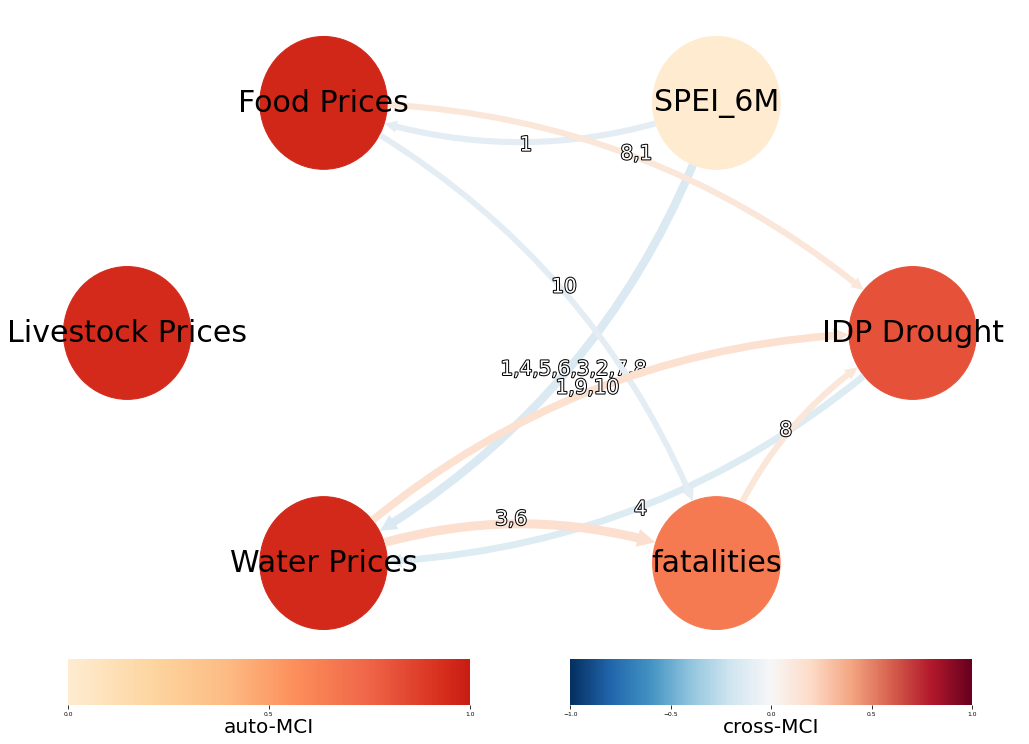

Diinsoor


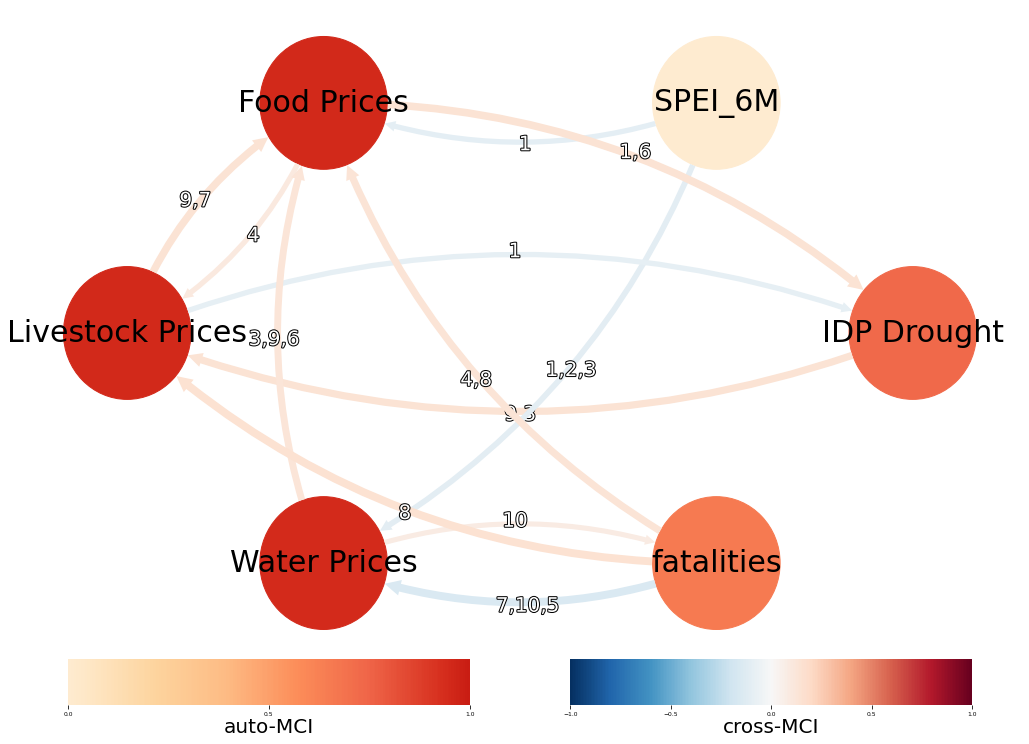

Kurtunwaarey


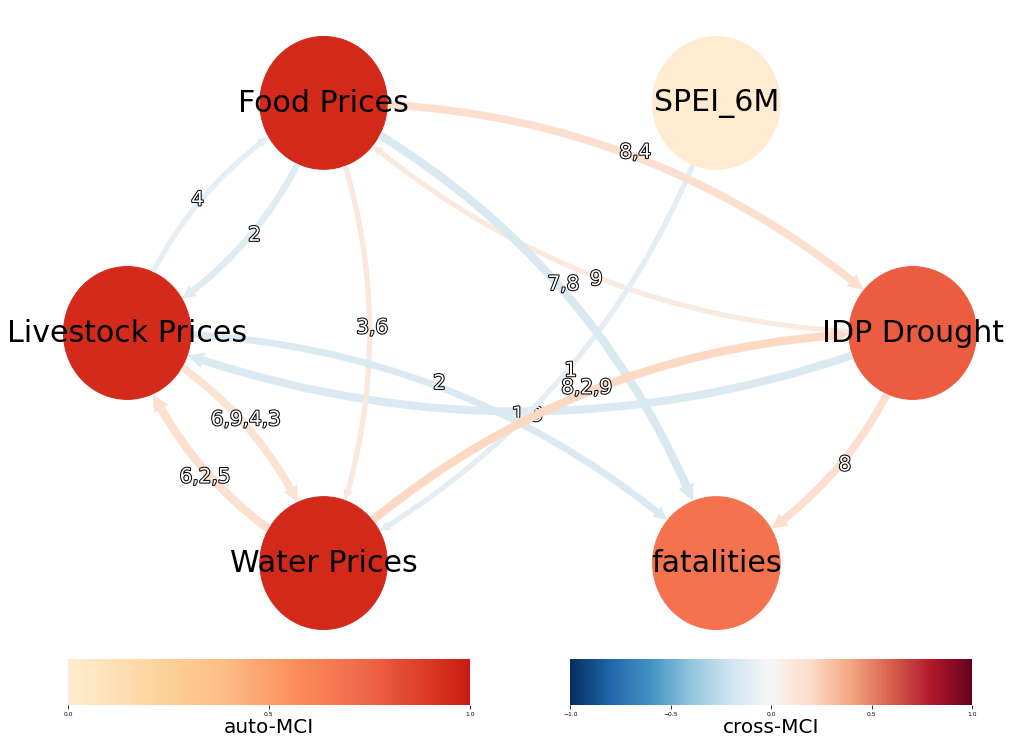

In [23]:
# Load data and run pipeline:

Somalia_IDP_Database = pd.read_csv('UC2_District_aggregation_data.csv')
Somalia_IDP_Database = Somalia_IDP_Database.iloc[:,1:]
Somalia_IDP_Database = Somalia_IDP_Database.rename(columns = {'time': 'Date', 'IDP_Drought': 'IDP Drought'})
Somalia_IDP_Database.Date = pd.to_datetime(Somalia_IDP_Database.Date)

Somalia_IDP_Database

districts = Somalia_IDP_Database.District.unique()
regions = pd.read_csv('Regions.csv', usecols = ['District','Region'])

districts = ['Baidoa', 'Diinsoor', 'Kurtunwaarey']

start_date = Somalia_IDP_Database.Date.min()
end_date = Somalia_IDP_Database.Date.max()

# Run for selected districts:
for district in districts:
    
    DATA_graph =  data_pipeline(district, Somalia_IDP_Database, 
                interp_market= 'quadratic', 
                deflate = True, 
                detrend = True, 
                window = 4,
                date_graph1 =  start_date, 
                date_graph2 = end_date)
    
    parcorr_pcmci = pcmci_graph_bootstrap(DATA = DATA_graph, 
        cond_ind_test = ParCorr(verbosity=0, mask_type='y'), 
        tau_min = 1,  
        tau_max = 10, 
        alpha_level = 0.05, 
        pc_alpha = 0.05, 
        mask_threshold = 1, 
        boot_samples = 100)
            

# Robustness Tests

Baidoa


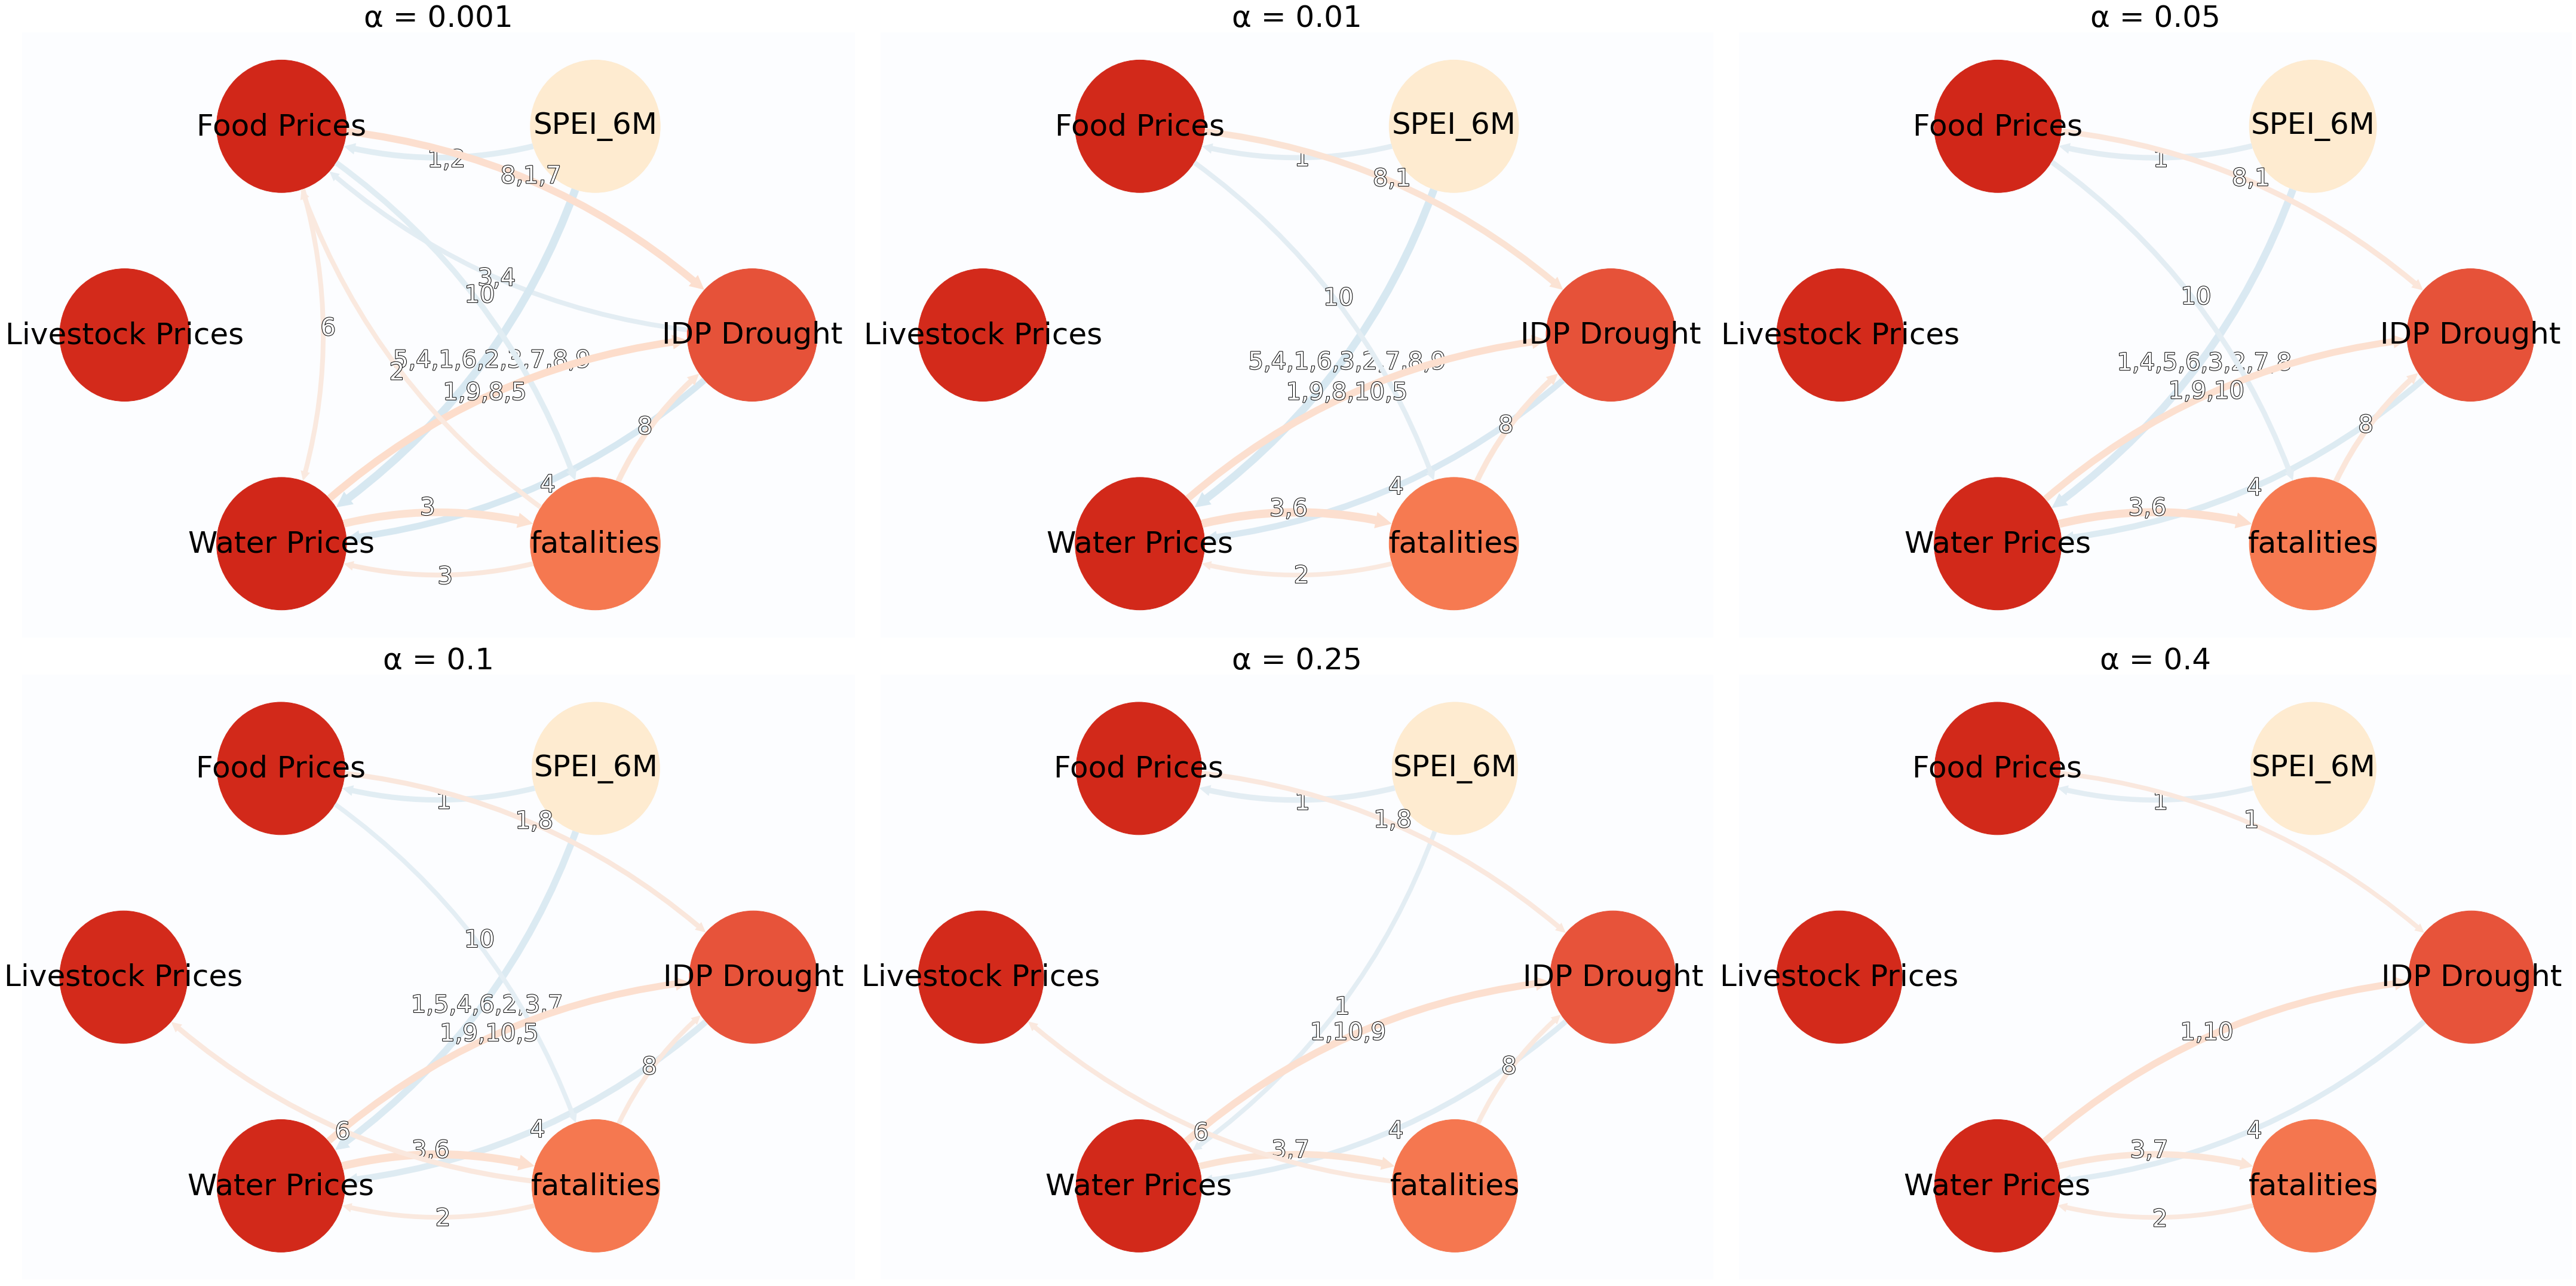

Diinsoor


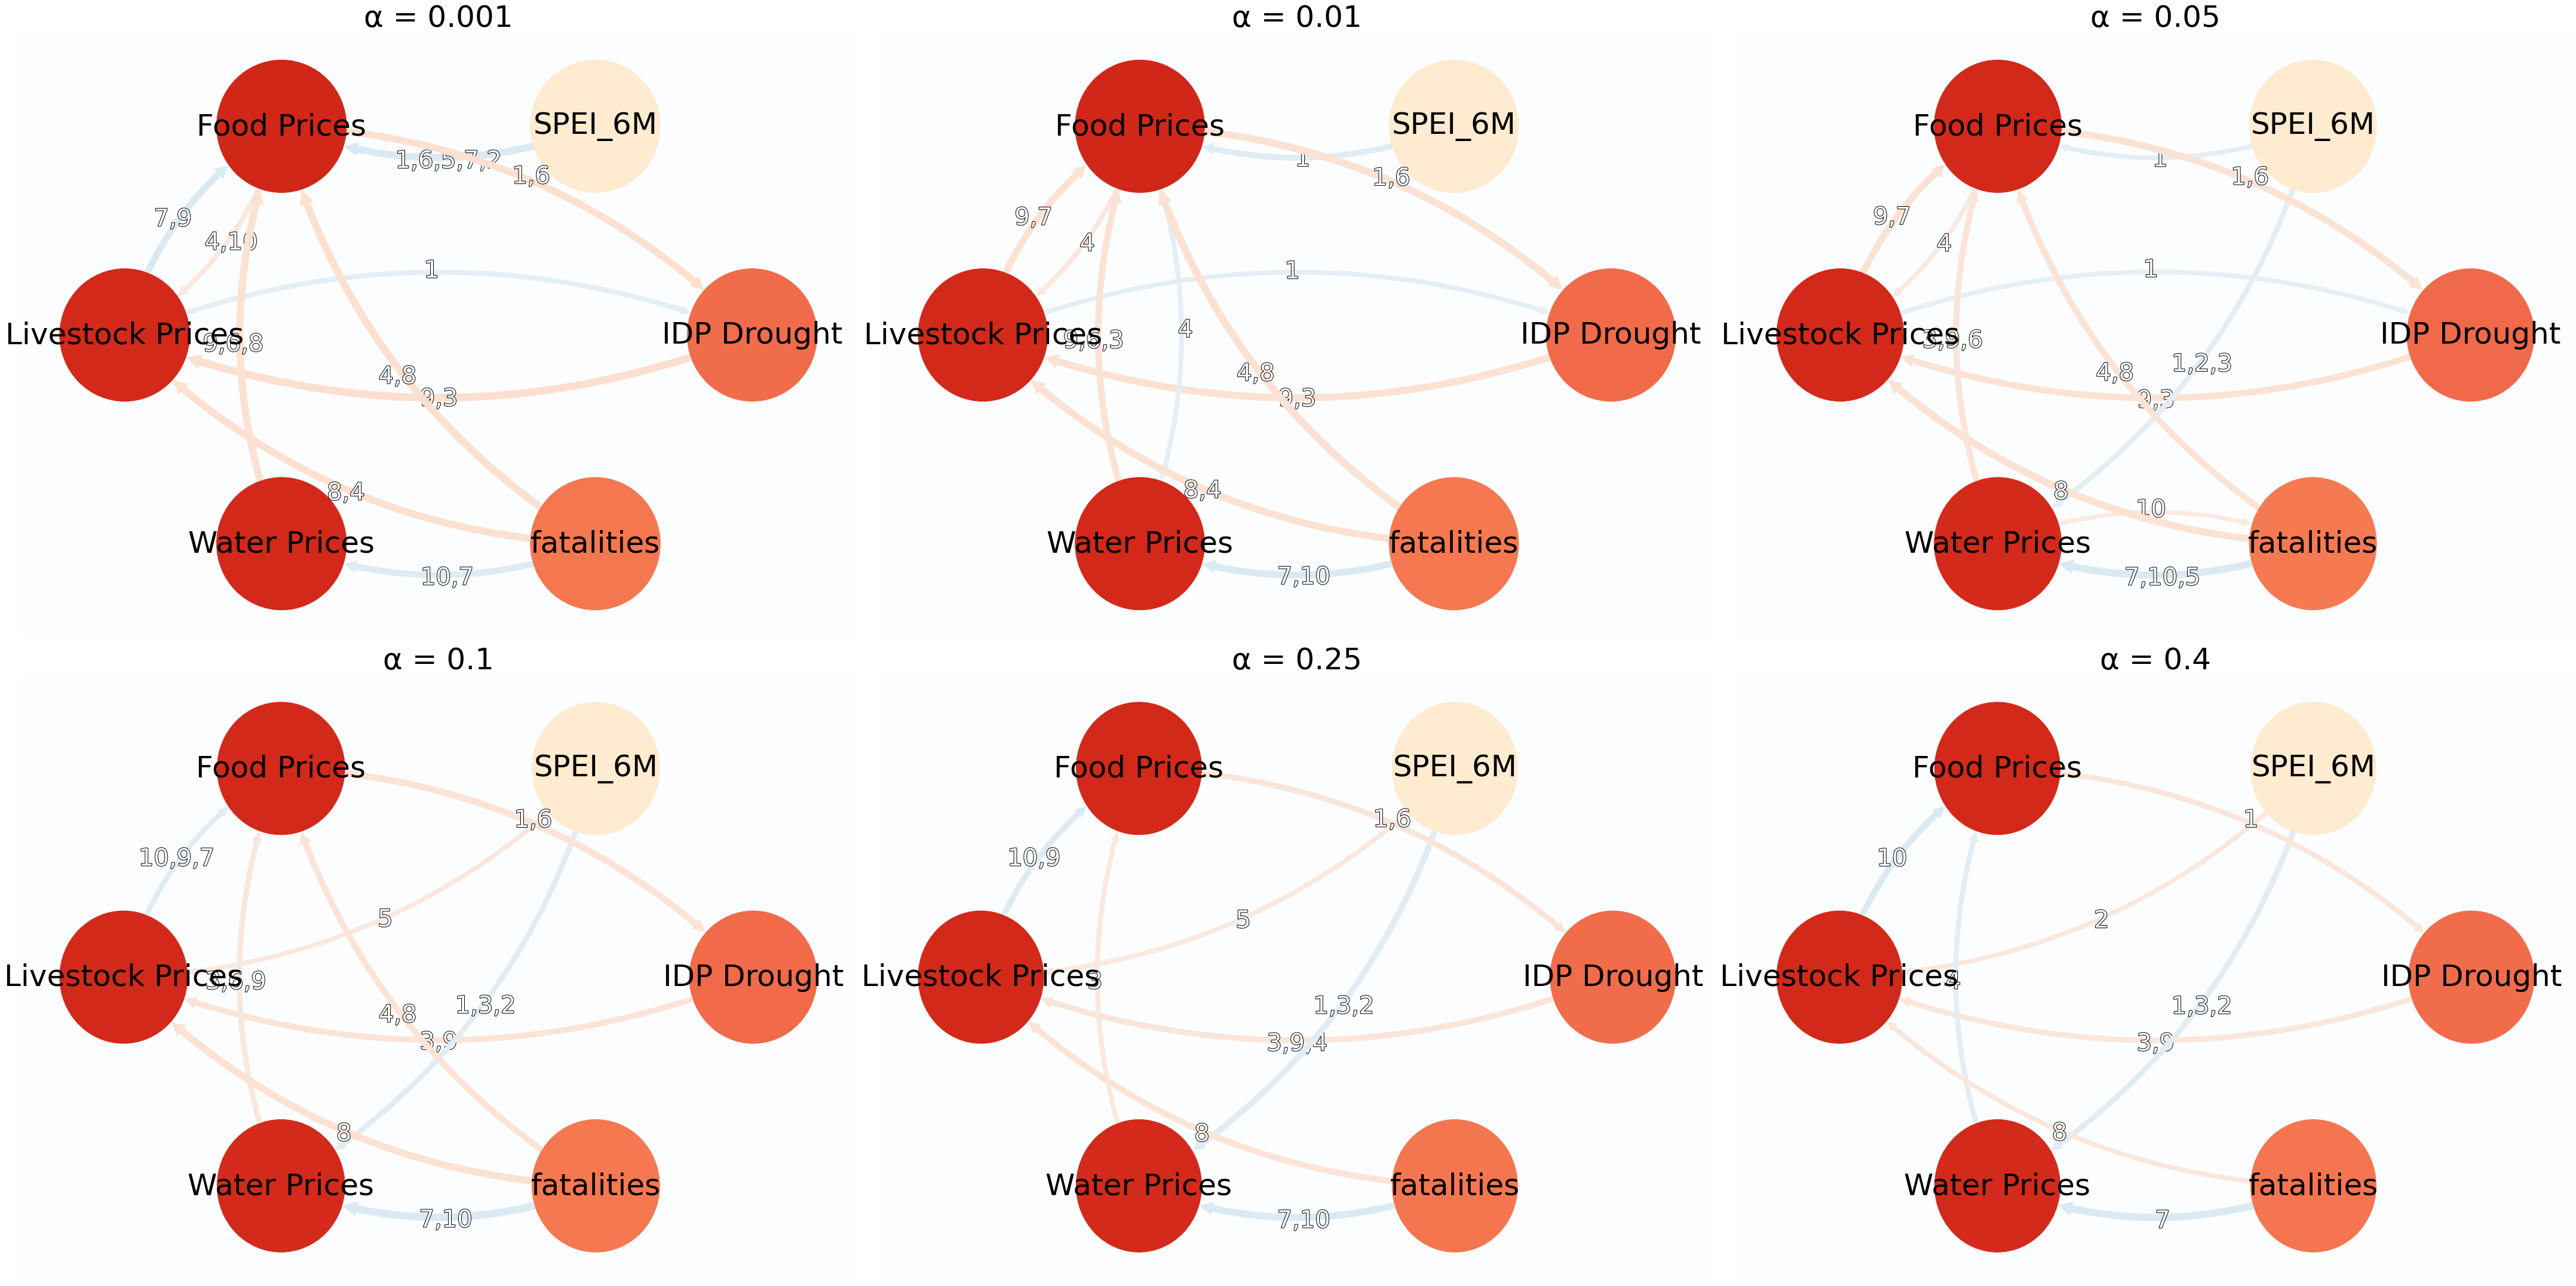

Kurtunwaarey


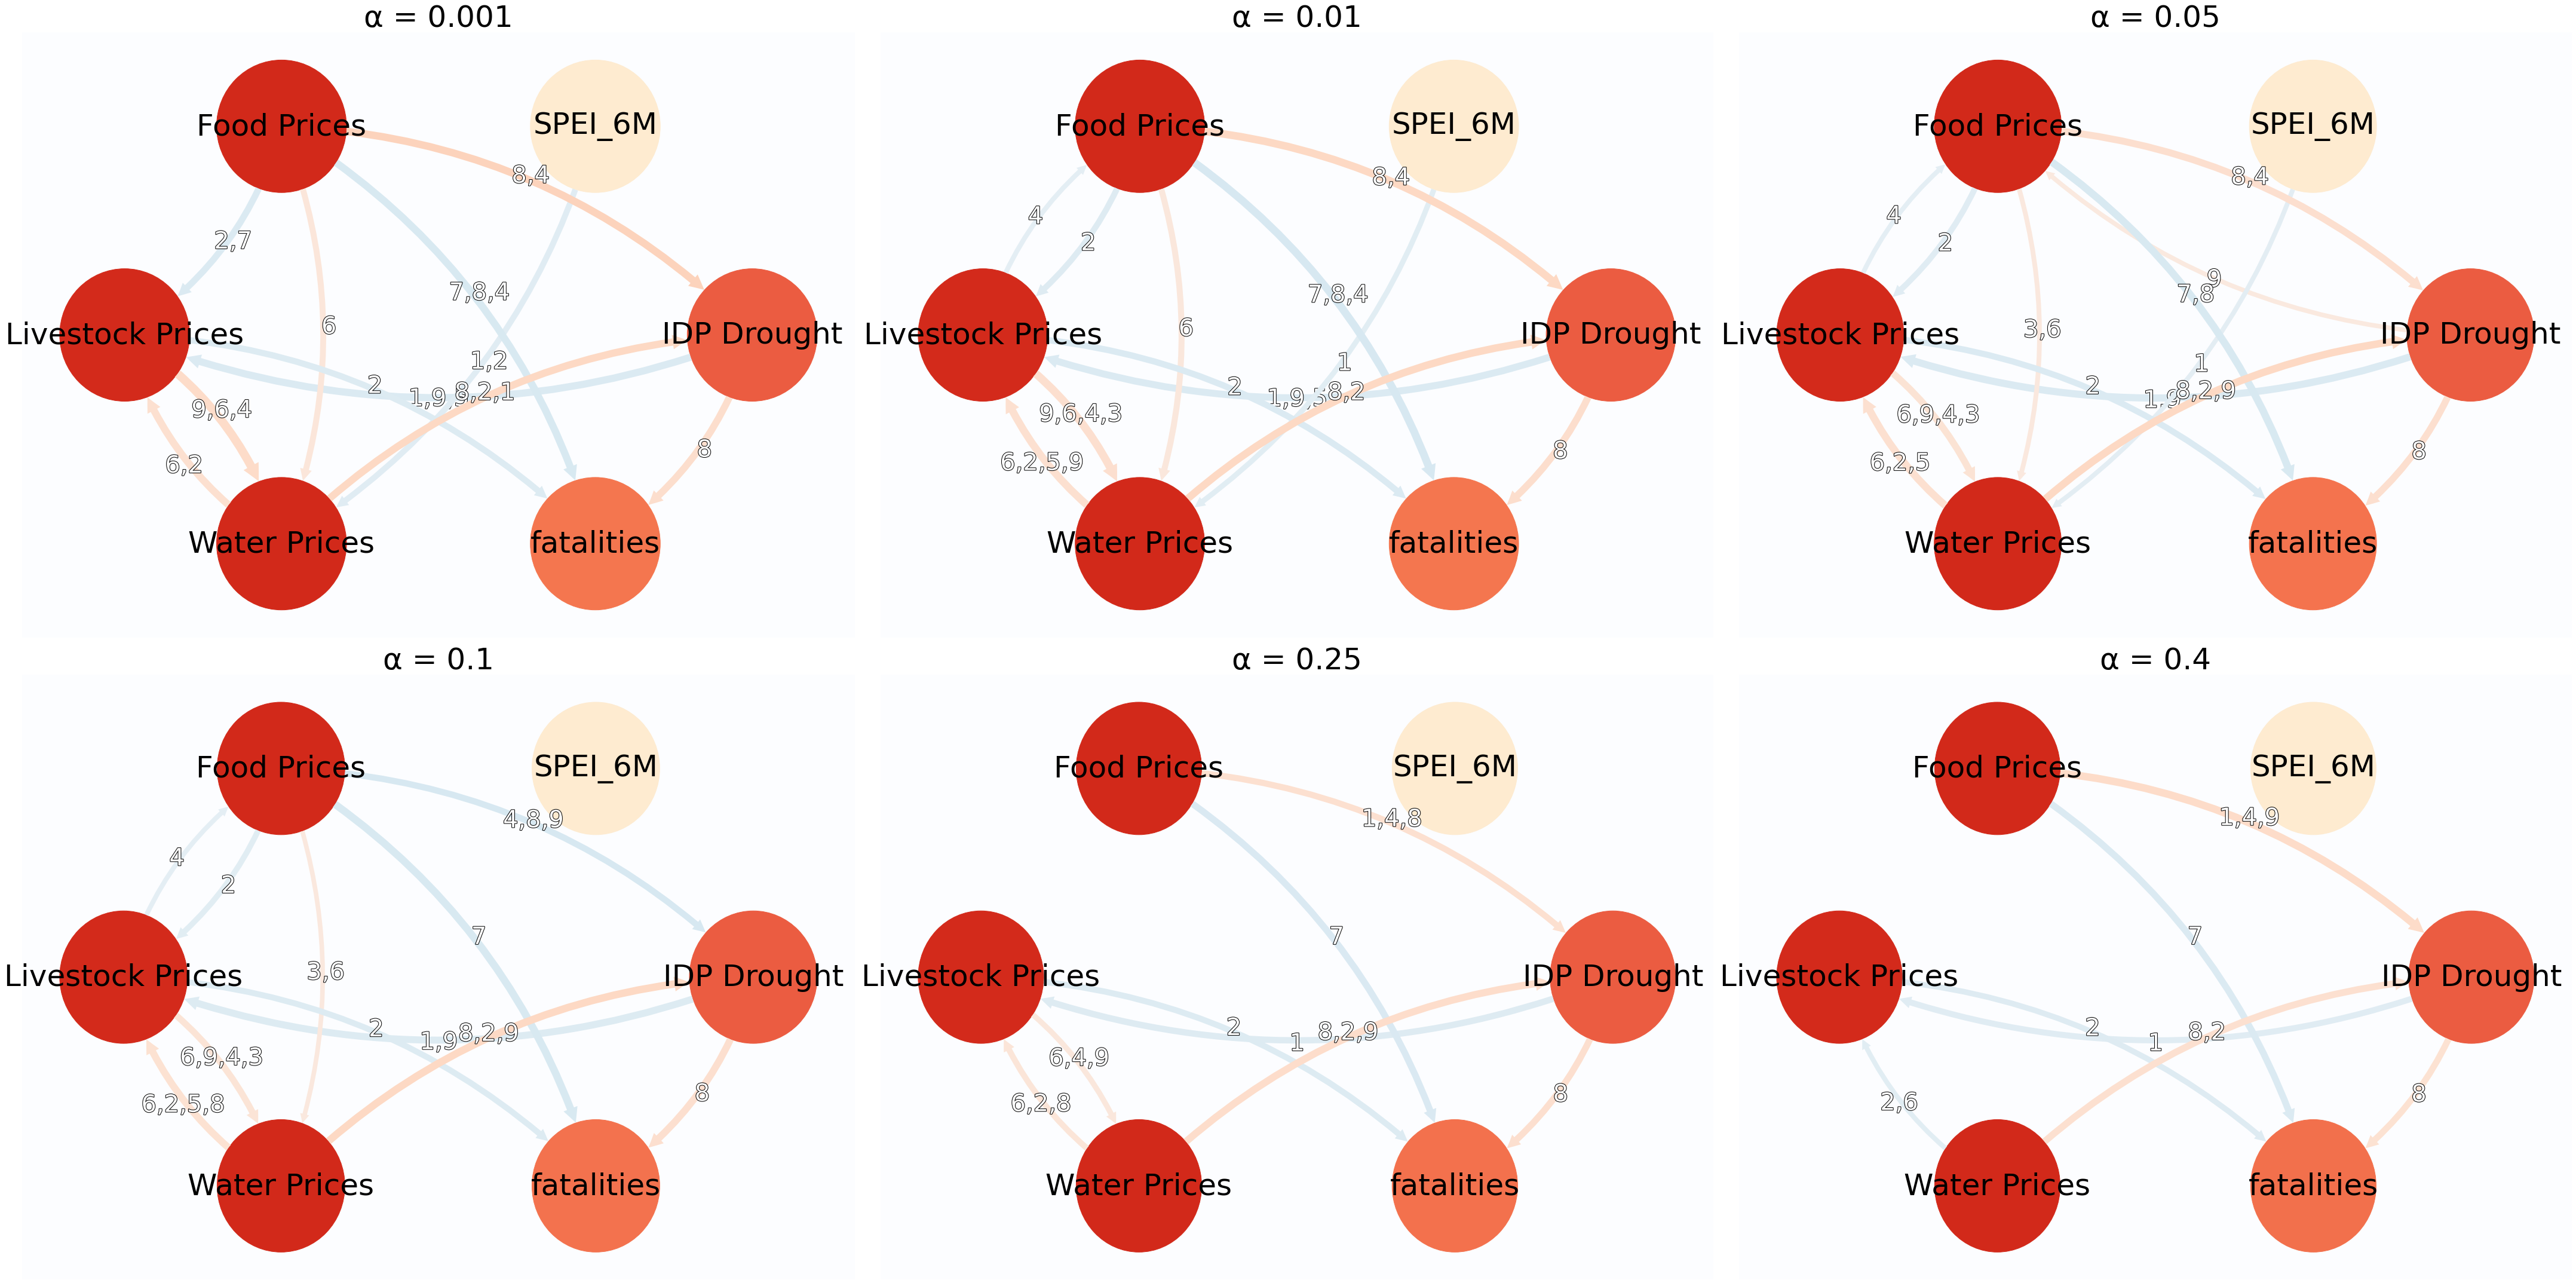

In [28]:
districts = ['Baidoa', 'Diinsoor', 'Kurtunwaarey']

# Run for selected districts:
for district in districts:
    
    DATA_graph =  data_pipeline(district, Somalia_IDP_Database, 
                interp_market= 'quadratic', 
                deflate = True, 
                detrend = True, 
                window = 4,
                date_graph1 =  start_date, 
                date_graph2 = end_date)

    parcorr_pcmci_robust = pcmci_graph_robustness_bootstrap(DATA = DATA_graph, 
        cond_ind_test = ParCorr(verbosity=0, mask_type='y'), 
        tau_min = 1,  
        tau_max = 10, 
        alpha_level = 0.05, 
        alpha_list = [0.001, 0.01, 0.05, 0.1, 0.25, 0.4], 
        mask_threshold = 1, 
        boot_samples = 100)
            

# Additional Districts:


Belet Weyne


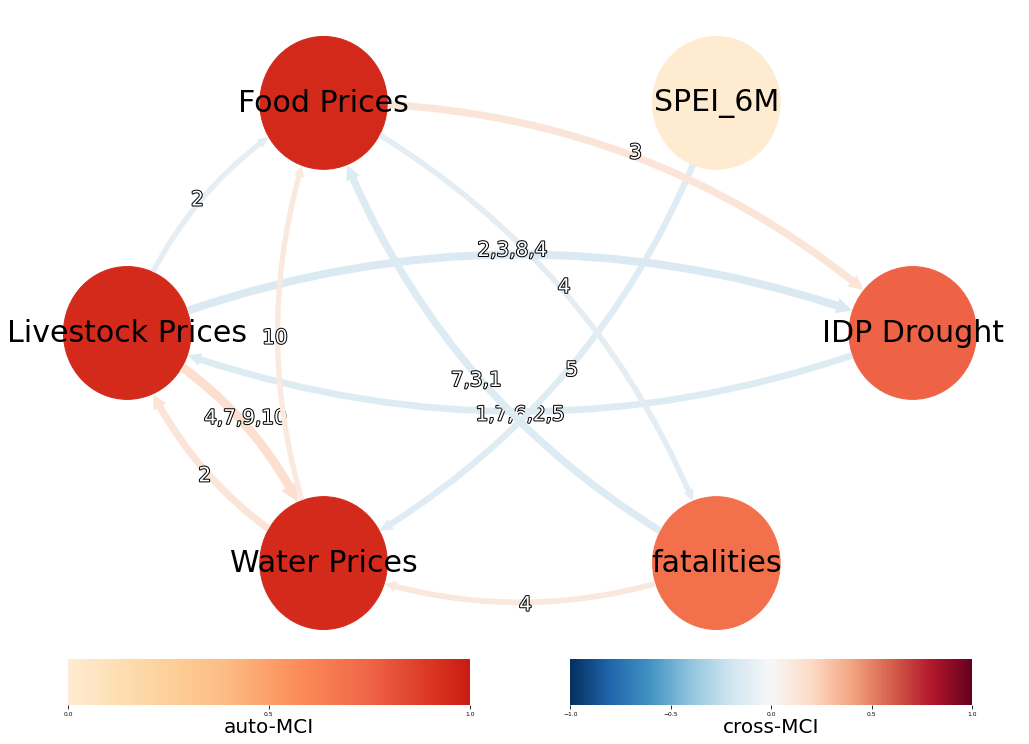

Qansax Dheere


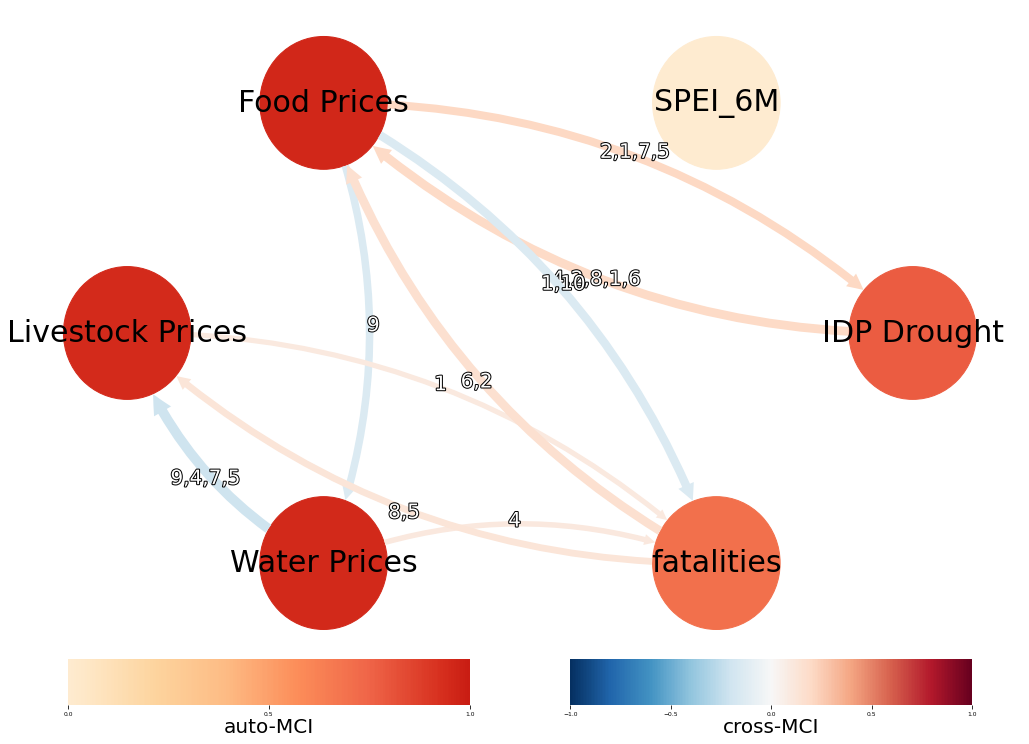

Kismayo


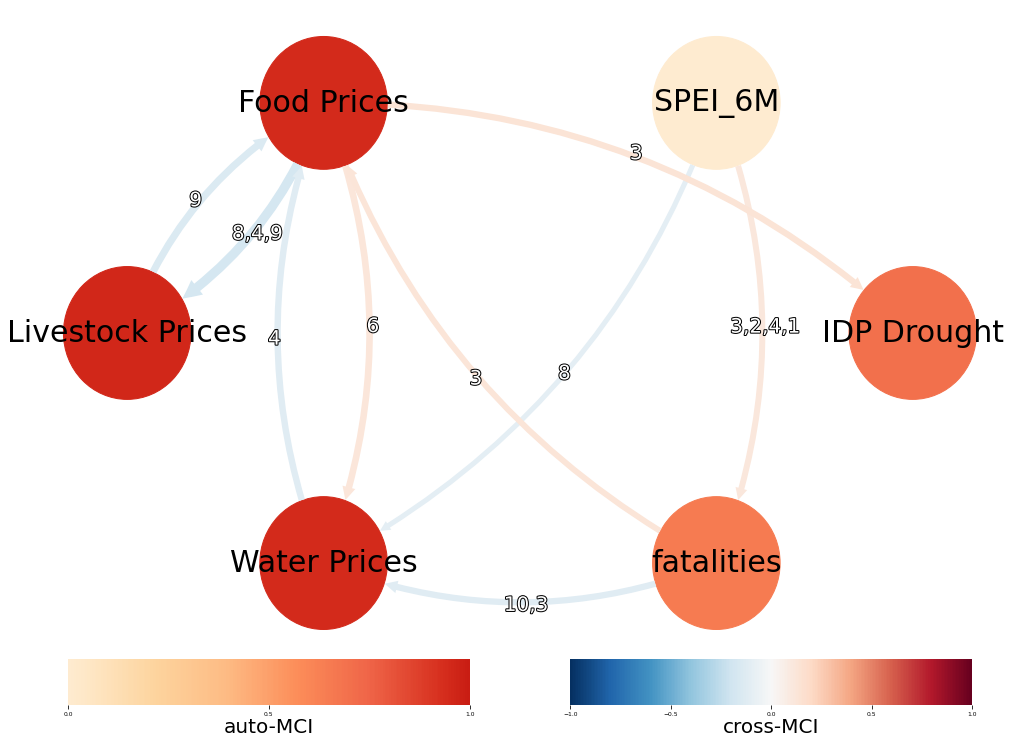

Buur Hakaba


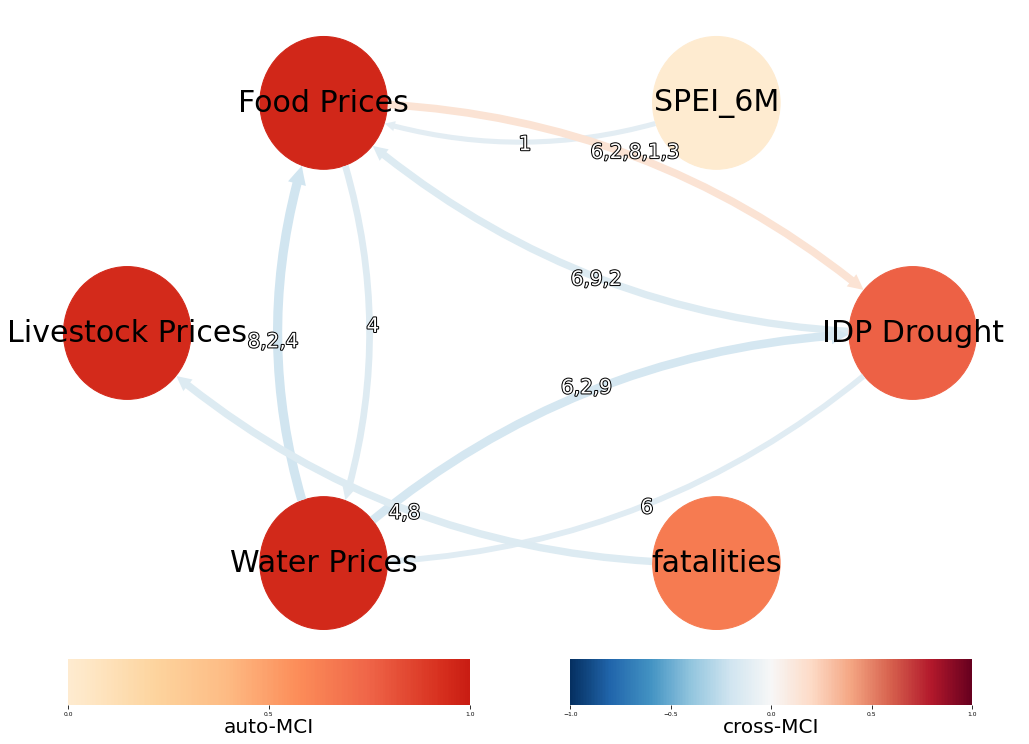

In [24]:
districts = ['Belet Weyne', 'Qansax Dheere', 'Kismayo', 'Buur Hakaba']

# Run for selected districts:
for district in districts:
    
    DATA_graph =  data_pipeline(district, Somalia_IDP_Database, 
                interp_market= 'quadratic', 
                deflate = True, 
                detrend = True, 
                window = 4,
                date_graph1 =  start_date, 
                date_graph2 = end_date)
    
    parcorr_pcmci = pcmci_graph_bootstrap(DATA = DATA_graph, 
        cond_ind_test = ParCorr(verbosity=0, mask_type='y'), 
        tau_min = 1,  
        tau_max = 10, 
        alpha_level = 0.05, 
        pc_alpha = 0.05, 
        mask_threshold = 1, 
        boot_samples = 100)